In [56]:
#This notebook runs with pandas 0.24.2

#version alpha 0.3, Bayardo
#version alpha 0.4, Bayardo
#version alpha 0.5, Bayardo y Grace
#version alpha 0.8, Bayardo, Grace y Rigoberto
#version alpha 0.9
#version beta 1.0, Full team
#version beta 1.1, Full team

#The project analyses two data sets:

# Data extracted with an API from the World Bank: 14 indexes of mexican population desagregated from the Human Development Index
# Data extracted with a CSV from Google Trends: 25 categories of searches from the mexican population

#Objective : Find if the data from the indexes in the period from 2008 to 2017 is correlated with the Google searches
#           H0= There would be no correlation between the indexes and the trends of searches
#           H1= We will find correlations particularly with indexes related to education and 'Science and Tech' searches

In [2]:
# Dependencies
import requests
import pandas
import numpy
import matplotlib.pyplot as plt
import statsmodels.api
import seaborn as sns

In [3]:
#Using the World Bank API documentation, define the strings to create the neccesary URLs
#In this case, "mx" stands for Mexico, and "date=2004:2014" for the period of time we are interested

#Define important parameters for the API. In this case, country code and period of time we want the info to.
country_2_letter_code = "mx"
time_period = "2004:2014"

worldbank_url_prefix = "http://api.worldbank.org/v2/country/" + country_2_letter_code + "/indicator/"
worldbank_url_sufix = "?format=json&date=" + time_period

In [4]:
#Declare a list of indicators we are interested
#We get this list by initially requesting "http://api.worldbank.org/v2/indicator?format=json&per_page=20000"
#which is the list of all available indicators.
#From there you can find the indicators ID of whatever you are interested in.
indicators_partial = ["SP.ADO.TFRT", "NV.AGR.TOTL.ZS", "EN.ATM.CO2E.PC", "FS.AST.DOMS.GD.ZS", "EG.USE.ELEC.KH.PC",
                      "NY.GNP.PCAP.PP.CD", "NE.GDI.TOTL.ZS", "TX.VAL.TECH.MF.ZS", "NV.IND.TOTL.ZS", "NY.GDP.DEFL.KD.ZG",
                      "SE.PRM.CMPT.ZS", "DT.TDS.DECT.EX.ZS"]

In [5]:
#Create empty list for the name of the indicators
indicators = []

#Create an empty dict for the results
years = {}

for indicator in indicators_partial:
    response = requests.get(worldbank_url_prefix + indicator + worldbank_url_sufix).json()
    
    for row in response[1]:
    #Every response includes a [0] element which is the status of the response, and the [1] the data itself
        
        #Verify the name of the indicator (in plain english), and add them to list for the name of the columns
        #in the dataframe
        if row["indicator"]["value"] not in indicators:
            indicators.append(row["indicator"]["value"])
        
        #Verify the year as a key for a dictionary. Store the value as an element in a list, associated in
        #for each year
        
        #You must convert the date from string to integer, in order to avoid issues when merging with the other df
        year = int(row["date"])
        if year not in years.keys():
            years[year] = []
        
        years[year].append(row["value"])

In [6]:
#Join the dictionary full of data, and the list of indicatiors as parameters for the dataframe. We include the
#orient='index' option, to create the dataframe using dictionary keys as rows, and then the columns from the
#indicators list, the sort the years in an ascending way, and rename the index column as "Year"
worldbank_df = pandas.DataFrame.from_dict(data=years, orient='index', columns=indicators).sort_index(ascending=True).rename_axis(index="Year")
worldbank_df.style.format("{:,.2f}")

,"Adolescent fertility rate (births per 1,000 women ages 15-19)","Agriculture, forestry, and fishing, value added (% of GDP)",CO2 emissions (metric tons per capita),Domestic credit provided by financial sector (% of GDP),Electric power consumption (kWh per capita),"GNI per capita, PPP (current international $)",Gross capital formation (% of GDP),High-technology exports (% of manufactured exports),"Industry (including construction), value added (% of GDP)","Inflation, GDP deflator (annual %)","Primary completion rate, total (% of relevant age group)","Total debt service (% of exports of goods, services and primary income)"
Year,,,,,,,,,,,,
2004,73.80,3.34,4.12,30.87,"1,882.40","11,340.00",21.49,21.29,32.85,7.96,98.45,19.10
2005,72.63,3.07,4.30,31.01,"1,950.99","12,110.00",22.13,19.64,32.78,5.87,98.84,15.51
2006,71.46,3.08,4.35,34.04,"1,974.47","13,230.00",22.82,18.98,34.20,6.39,98.58,19.90
2007,70.30,3.18,4.30,36.62,"1,998.72","13,760.00",23.12,17.18,33.84,5.79,98.48,12.73
2008,69.43,3.16,4.34,36.72,"1,995.44","14,350.00",24.11,15.73,34.76,6.17,96.86,11.09
2009,68.56,3.24,4.12,42.90,"1,942.76","13,930.00",22.89,18.18,31.89,3.95,94.41,12.67
2010,67.70,3.22,3.96,43.64,"1,963.31","14,680.00",22.79,16.94,32.36,4.55,94.02,10.11
2011,66.83,3.09,4.07,44.09,"2,153.72","15,790.00",23.28,16.51,33.56,5.84,94.07,11.21
2012,65.97,3.17,4.11,45.63,"2,187.23","16,340.00",23.89,16.34,33.78,4.07,100.41,17.82


In [7]:
#Now we load the downloaded data from Google trends
searches = pandas.read_csv("Resources/Google_trends_searches.csv", index_col="Year")
searches.head()

,Month,Art,Cars,Beauty,Real estate,Science,Food,Shoppings,Communities,Sports,...,Law,Books,Pets,News,Hobbies,People,Reference,Health,Jobs,Travels
Year,,,,,,,,,,,,,,,,,,,,,
2004,1,43,40,24,35,61,28,47,10,21,...,61,72,46,30,43,53,49,43,67,37
2004,2,44,43,26,38,84,32,52,10,22,...,69,83,48,31,50,60,60,52,63,41
2004,3,48,43,27,37,82,34,46,10,24,...,76,86,50,34,46,63,60,58,60,47
2004,4,44,41,25,35,62,30,46,10,23,...,60,75,45,29,42,53,48,47,55,44
2004,5,47,44,28,39,72,35,50,10,25,...,71,86,54,34,49,63,53,56,67,45


In [8]:
#The original data from Google has to 2 initial issues to be solved:
#1) The data is disaggregated by months, so it must be group by years
#2) The data includes years 2015 to 2019, which has no correspondence in the World Bank dataset
#To solve both issues, we drop the month column and the 2015-2019 year range of rows, then we group the remaining
#by year and, using the mean as value for each year
#Finally we present the data using the style.format method
googletrends_df = searches.drop("Month", axis=1).drop(list(numpy.arange(2019, 2014, -1)), axis=0).groupby("Year").sum()
googletrends_df.style.format("{:,.1f}")

,Art,Cars,Beauty,Real estate,Science,Food,Shoppings,Communities,Sports,Business,Finances,Home,Informatics,Internet,Games,Law,Books,Pets,News,Hobbies,People,Reference,Health,Jobs,Travels
Year,,,,,,,,,,,,,,,,,,,,,,,,,
2004,568.0,532.0,331.0,462.0,848.0,398.0,619.0,135.0,315.0,787.0,509.0,384.0,992.0,409.0,495.0,807.0,952.0,584.0,408.0,588.0,725.0,674.0,604.0,760.0,536.0
2005,647.0,615.0,359.0,543.0,820.0,426.0,669.0,187.0,348.0,792.0,608.0,413.0,984.0,524.0,555.0,874.0,998.0,617.0,467.0,600.0,806.0,743.0,626.0,824.0,603.0
2006,717.0,645.0,394.0,620.0,759.0,445.0,698.0,219.0,431.0,751.0,683.0,430.0,938.0,577.0,639.0,909.0,919.0,644.0,576.0,590.0,788.0,725.0,621.0,837.0,681.0
2007,857.0,699.0,428.0,692.0,740.0,498.0,712.0,311.0,419.0,758.0,761.0,469.0,969.0,661.0,780.0,903.0,907.0,651.0,570.0,605.0,821.0,749.0,644.0,914.0,793.0
2008,997.0,732.0,453.0,770.0,730.0,522.0,710.0,439.0,454.0,769.0,828.0,505.0,987.0,704.0,922.0,921.0,867.0,672.0,611.0,622.0,851.0,772.0,660.0,947.0,769.0
2009,950.0,648.0,438.0,724.0,639.0,483.0,644.0,446.0,424.0,677.0,751.0,475.0,885.0,685.0,908.0,802.0,763.0,621.0,608.0,550.0,778.0,722.0,616.0,871.0,647.0
2010,790.0,552.0,428.0,620.0,513.0,418.0,537.0,499.0,371.0,558.0,602.0,401.0,705.0,659.0,750.0,705.0,635.0,525.0,525.0,446.0,662.0,643.0,503.0,696.0,536.0
2011,"1,133.0",781.0,758.0,844.0,722.0,644.0,803.0,966.0,506.0,806.0,886.0,607.0,955.0,"1,013.0","1,057.0","1,056.0","1,004.0",836.0,694.0,662.0,968.0,941.0,734.0,974.0,764.0
2012,"1,122.0",864.0,861.0,846.0,727.0,723.0,891.0,"1,034.0",545.0,834.0,979.0,683.0,930.0,"1,051.0","1,002.0","1,027.0","1,044.0","1,038.0",708.0,758.0,"1,071.0",911.0,797.0,957.0,785.0


In [9]:
#Now we create a function to correlate the data in the two dataframes

#You can also using this instruction, but it's less efficient
#pandas.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr().loc['df2', 'df1']

def find_corr(df1, df2):
    n = len(df1)
    v1, v2 = df1.values, df2.values
    sums = numpy.multiply.outer(v2.sum(0), v1.sum(0))
    stds = numpy.multiply.outer(v2.std(0), v1.std(0))
    
    return pandas.DataFrame((v2.T.dot(v1) - sums / n) / stds / n, df2.columns, df1.columns)

In [10]:
#Now we create a function to color the most correlated variables in the result
#Correlation can be direct (closer to positive 1), or inverse (closer to negative 1), in both cases
#it will be colored red, because we evaluate the absolute value of each coefficient

correlation_threshold = 0.9
def color_red_highest(val):
    color = 'red' if abs(val) >= correlation_threshold else 'black'
    return 'color: %s' % color

In [11]:
#Now we can use the previously created functions to create a correlation matrix between the datasets
#and immediately after present the result in a colored, more visual way
correlations_df = find_corr(worldbank_df, googletrends_df)
correlations_df.style.applymap(color_red_highest)

,"Adolescent fertility rate (births per 1,000 women ages 15-19)","Agriculture, forestry, and fishing, value added (% of GDP)",CO2 emissions (metric tons per capita),Domestic credit provided by financial sector (% of GDP),Electric power consumption (kWh per capita),"GNI per capita, PPP (current international $)",Gross capital formation (% of GDP),High-technology exports (% of manufactured exports),"Industry (including construction), value added (% of GDP)","Inflation, GDP deflator (annual %)","Primary completion rate, total (% of relevant age group)","Total debt service (% of exports of goods, services and primary income)"
Art,-0.889721,-0.299443,-0.435379,0.850303,0.860389,0.92276,0.526725,-0.883482,-0.0755876,-0.630575,0.251369,-0.542849
Cars,-0.842467,-0.402616,-0.452734,0.754981,0.801236,0.870608,0.155321,-0.730943,-0.226284,-0.620887,0.729044,-0.348369
Beauty,-0.904342,-0.302805,-0.656221,0.856587,0.865402,0.916022,0.0943533,-0.691585,-0.337628,-0.661912,0.632397,-0.341543
Real estate,-0.918852,-0.376462,-0.456819,0.859087,0.845028,0.949548,0.418781,-0.885832,-0.138324,-0.647977,0.413004,-0.528395
Science,0.469601,-0.112543,0.438151,-0.553544,-0.0812714,-0.407437,-0.315996,0.484757,0.267619,0.480257,0.383453,0.588796
Food,-0.881118,-0.308025,-0.600571,0.814276,0.80627,0.891697,0.0620991,-0.693592,-0.33777,-0.628983,0.718166,-0.351978
Shoppings,-0.742266,-0.406695,-0.403947,0.652695,0.794143,0.780181,0.0572911,-0.584749,-0.1983,-0.528117,0.784928,-0.170748
Communities,-0.921315,-0.263526,-0.64931,0.902501,0.893991,0.932642,0.271514,-0.761709,-0.273804,-0.722181,0.400307,-0.44622
Sports,-0.890693,-0.400347,-0.502948,0.814331,0.820993,0.921664,0.213223,-0.763226,-0.20857,-0.585517,0.625319,-0.34231
Business,-0.303979,-0.335481,-0.0965541,0.191866,0.52938,0.358999,-0.144648,-0.180882,-0.0298619,-0.119114,0.77077,0.137724


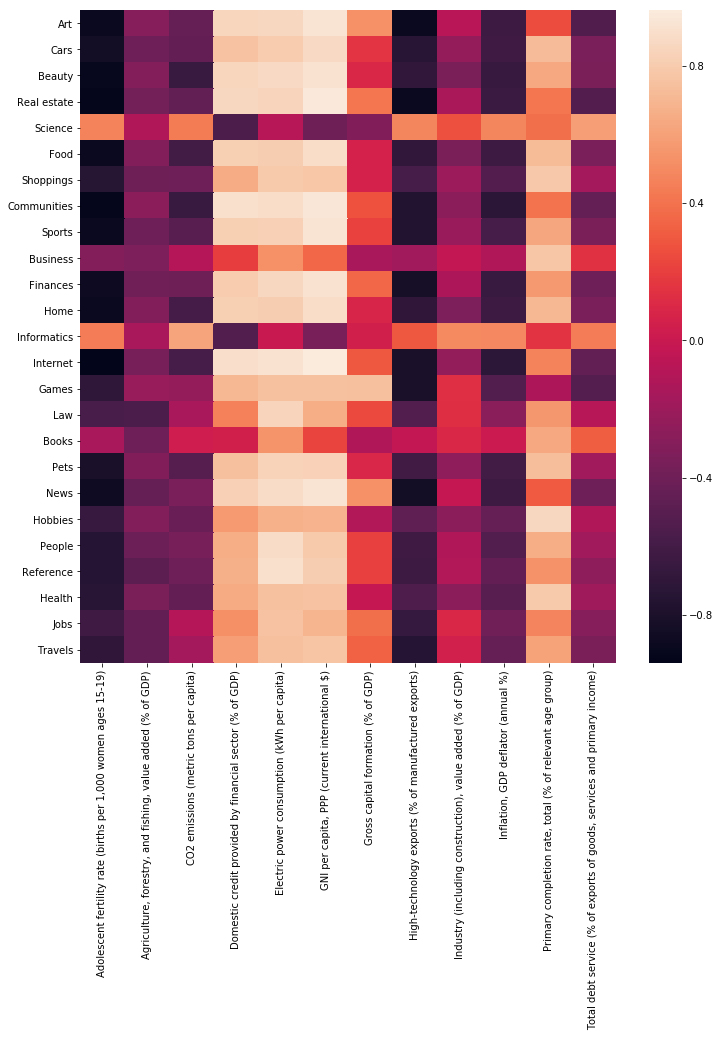

In [12]:
plt.rcParams['figure.figsize']=(12,12)
sns.heatmap(correlations_df)

In [13]:
#Now we create a function to analitically identify the most correlated variables

#The function temporary stores the best correlated variables in a list of list, named "bestcorrelations_list",
#then it creates a dataframe with this list, named "bestcorrelations_df"

def best_corr_2df(df, t=0.9):
    #df is the correlations dataframe, and t is the desire threshold
    correlation_row = []
    bestcorrelations_list = []
    #for i in range(len(df.unstack())):
        
        #Basically we unstack all the values in the correlation matrix and order all the results in a descending way
        #Then we slice the results, so we skip all the mirror coefficients (which always will be a perfect 1),
        #and selecting only one of each pair of results (e.g. var1 vs var2 is the same as var2 vs var1) by skipping
        #the second one on the slicing
    for variables, correlation in correlations_df.unstack().items():
    
        if abs(correlation) >= t:
            correlation_row = list(variables)
            correlation_row.append(abs(correlation))
            if correlation >= 0:
                correlation_row.append("Direct")
            else:
                correlation_row.append("Inverse")
        
                #Create a list of lists
            bestcorrelations_list.append(correlation_row)
    
    #Now we create the final results dataframe, and add some formatting
    bestcorrelations_df = pandas.DataFrame(bestcorrelations_list, columns=["Variables from 1st df", \
                                                                           "Variables from 2nd df", \
                                                                           "Correlation coefficient", \
                                                                           "Type of proportion"]).sort_values(by = ["Correlation coefficient"], ascending=False)
    
    return bestcorrelations_df

In [14]:
#Now we can just call the created function, and it will show us the most related variables between datasets
best_correlated_variables = best_corr_2df(correlations_df)

#And we do some styling for presenting the results
best_correlated_variables.reset_index(drop = True)\
                         .style.set_table_styles([dict(selector="th", props=[("text-align", "left")])])\
                               .set_properties(subset=["Variables from 1st df", "Variables from 2nd df", "Type of proportion"], **{'text-align': 'left'})\
                               .format({"Correlation coefficient": "{:.6f}"})

,Variables from 1st df,Variables from 2nd df,Correlation coefficient,Type of proportion
0,"GNI per capita, PPP (current international $)",Internet,0.961117,Direct
1,"GNI per capita, PPP (current international $)",Real estate,0.949548,Direct
2,"Adolescent fertility rate (births per 1,000 women ages 15-19)",Internet,0.938696,Inverse
3,"GNI per capita, PPP (current international $)",Communities,0.932642,Direct
4,"GNI per capita, PPP (current international $)",Art,0.922760,Direct
5,"GNI per capita, PPP (current international $)",Sports,0.921664,Direct
6,"Adolescent fertility rate (births per 1,000 women ages 15-19)",Communities,0.921315,Inverse
7,"Adolescent fertility rate (births per 1,000 women ages 15-19)",Real estate,0.918852,Inverse
8,"GNI per capita, PPP (current international $)",News,0.917665,Direct
9,"GNI per capita, PPP (current international $)",Beauty,0.916022,Direct


In [15]:
#However, we don't just want a direct linear answer, instead we're looking for statistical weighted analysis
#so we count how many relevant relationships (correlation coefficient >= threshold) each one of this variables
#have on the variables of the other dataset

In [16]:
#The most influencial variables from one side
best_correlated_variables[["Variables from 1st df", "Variables from 2nd df"]]\
.groupby("Variables from 1st df")\
.count()\
.sort_values(["Variables from 2nd df"], ascending=False)\
.rename(columns={"Variables from 2nd df": "How many variables it's correlated on the other df"})\
.style.set_table_styles([dict(selector="th", props=[("text-align", "left")])])\
.set_properties(subset=["How many variables it's correlated on the other df"], **{"text-align": "center"})

,How many variables it's correlated on the other df
Variables from 1st df,
"GNI per capita, PPP (current international $)",8
"Adolescent fertility rate (births per 1,000 women ages 15-19)",4
Electric power consumption (kWh per capita),2
Domestic credit provided by financial sector (% of GDP),1


In [17]:
#The most influential variables from the other side
best_correlated_variables[["Variables from 2nd df", "Variables from 1st df"]]\
.groupby("Variables from 2nd df")\
.count()\
.sort_values(["Variables from 1st df"], ascending=False)\
.rename(columns={"Variables from 1st df": "How many variables it's correlated on the other df"})\
.style.set_table_styles([dict(selector="th", props=[("text-align", "left")])])\
.set_properties(subset=["How many variables it's correlated on the other df"], **{"text-align": "center"})

,How many variables it's correlated on the other df
Variables from 2nd df,
Communities,3
Internet,3
Beauty,2
Real estate,2
Art,1
Finances,1
News,1
Reference,1
Sports,1


In [18]:
restate = googletrends_df['Real estate']
food = googletrends_df['Food']
home = googletrends_df['Home']
fertility = worldbank_df['Adolescent fertility rate (births per 1,000 women ages 15-19)']
gni = worldbank_df['GNI per capita, PPP (current international $)']
#poverty = worldbank_df['Income share held by lowest 20%']
#%config InlineBackend.figure_format = 'svg'

In [19]:
from matplotlib.pyplot import *
%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

plt.rcParams['figure.figsize']=(12,10)

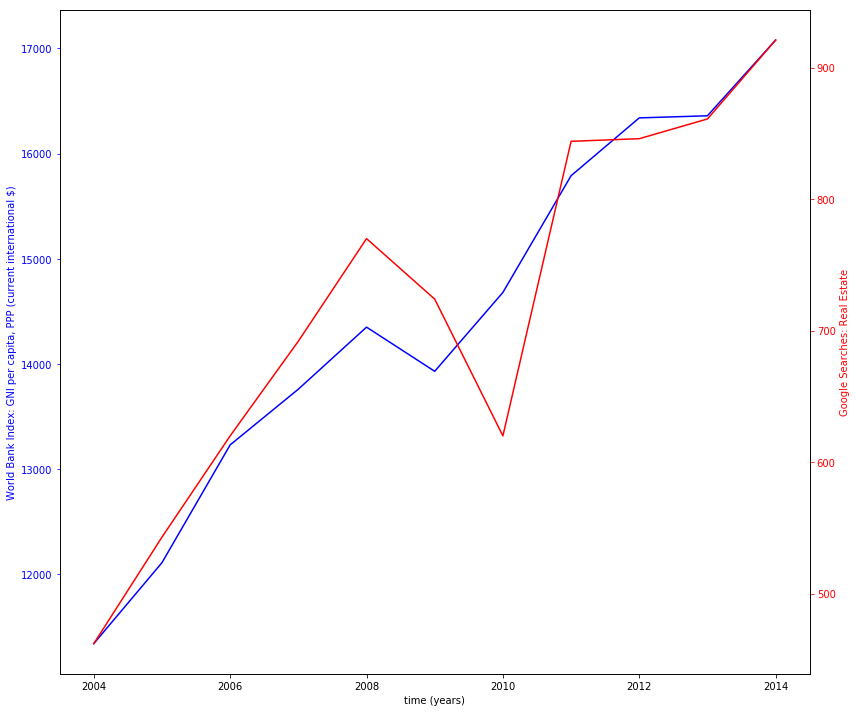

In [20]:
#GNI vs Real Estate searches
fig, ax1 = plt.subplots()
ax1.plot(worldbank_df.index, gni, 'blue')
ax1.set_xlabel('time (years)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('World Bank Index: GNI per capita, PPP (current international $)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(worldbank_df.index, restate, 'red')
ax2.set_ylabel('Google Searches: Real Estate', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
fig1 = plt.show()

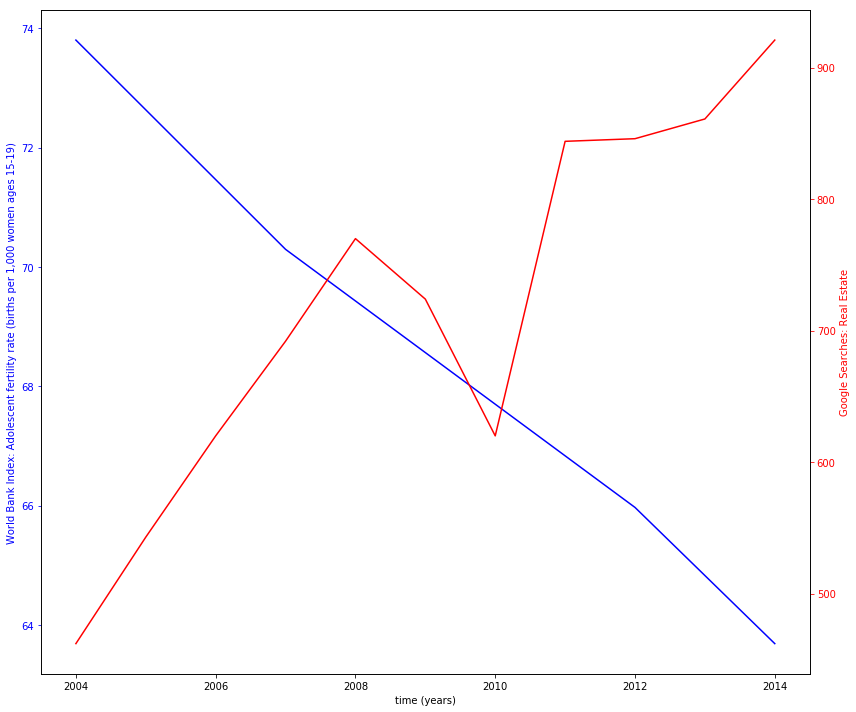

In [21]:
#Adolescent Fertility vs Real Estate searches
fig, ax1 = plt.subplots()
ax1.plot(worldbank_df.index, fertility, 'blue')
ax1.set_xlabel('time (years)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('World Bank Index: Adolescent fertility rate (births per 1,000 women ages 15-19)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(worldbank_df.index, restate, 'red')
ax2.set_ylabel('Google Searches: Real Estate', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
fig2 = plt.show()

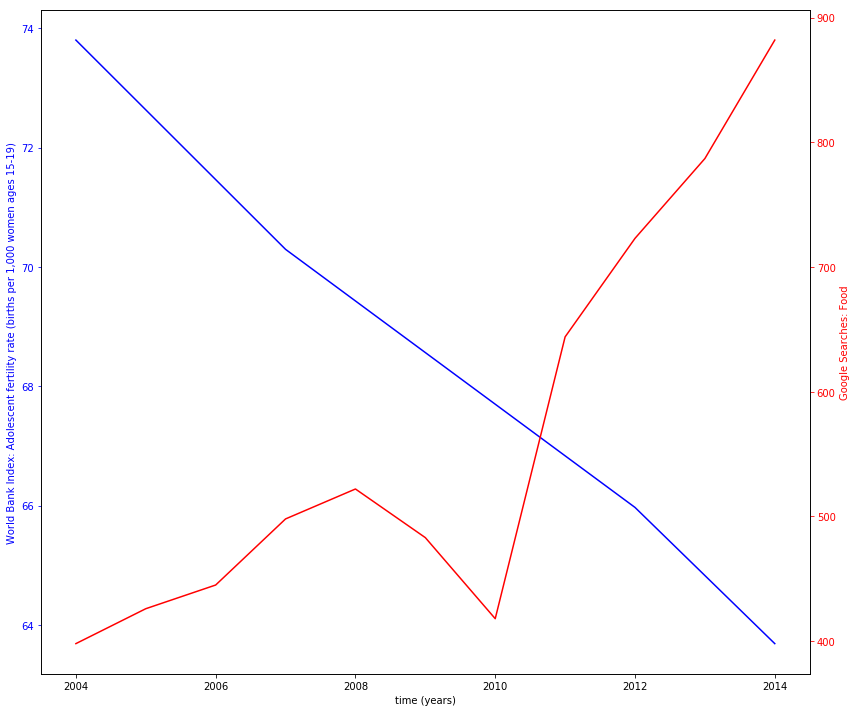

In [22]:
#Adolescent Fertility vs Food
fig, ax1 = plt.subplots()
ax1.plot(worldbank_df.index, fertility, 'blue')
ax1.set_xlabel('time (years)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('World Bank Index: Adolescent fertility rate (births per 1,000 women ages 15-19)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(worldbank_df.index, food, 'red')
ax2.set_ylabel('Google Searches: Food', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
fig3 = plt.show()  

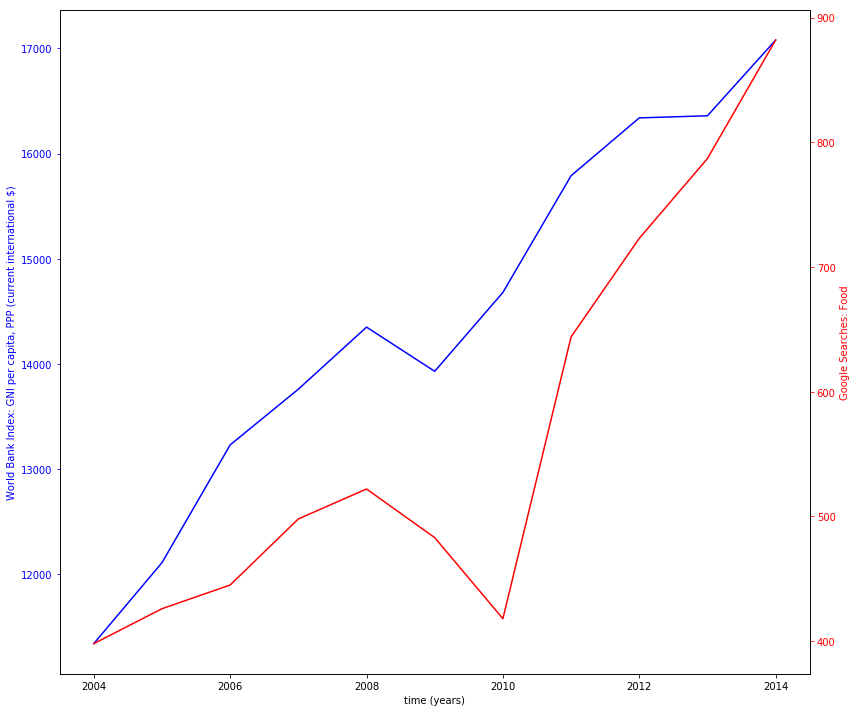

In [23]:
#GNI vs Food
fig, ax1 = plt.subplots()
ax1.plot(worldbank_df.index, gni, 'blue')
ax1.set_xlabel('time (years)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('World Bank Index: GNI per capita, PPP (current international $)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(worldbank_df.index, food, 'red')
ax2.set_ylabel('Google Searches: Food', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
fig4 = plt.show()

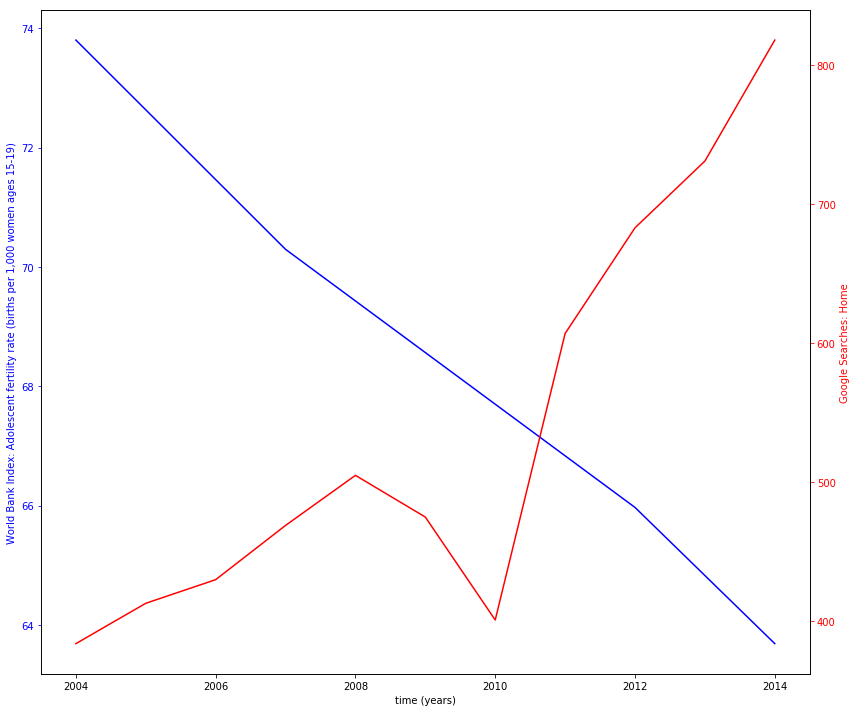

In [24]:
#Adolescent Fertility vs Home
fig, ax1 = plt.subplots()
ax1.plot(worldbank_df.index, fertility, 'blue')
ax1.set_xlabel('time (years)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('World Bank Index: Adolescent fertility rate (births per 1,000 women ages 15-19)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(worldbank_df.index, home, 'red')
ax2.set_ylabel('Google Searches: Home', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
fig5 = plt.show()

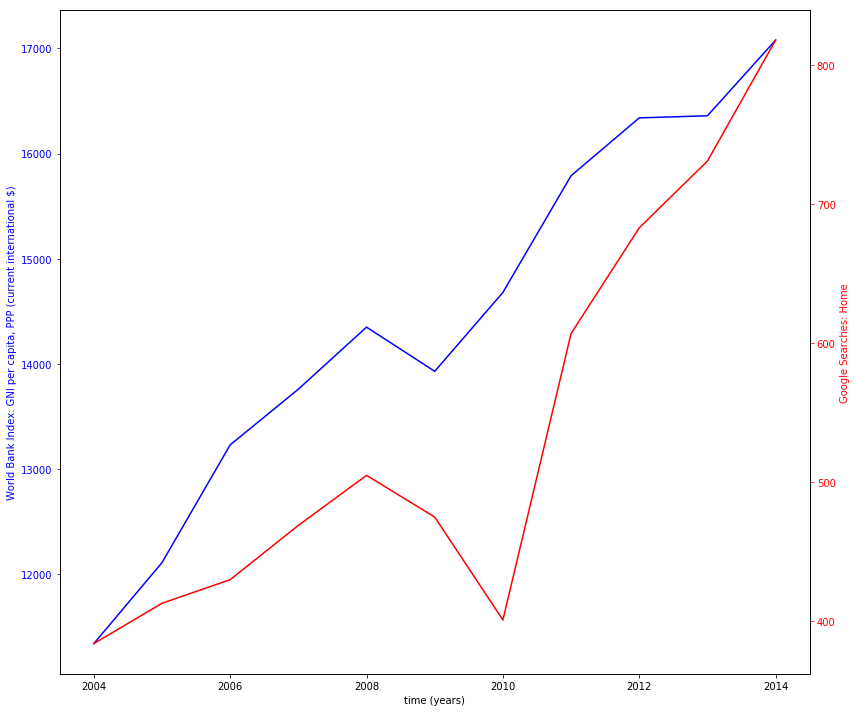

In [25]:
#GNI vs Home
fig, ax1 = plt.subplots()
ax1.plot(worldbank_df.index, gni, 'blue')
ax1.set_xlabel('time (years)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('World Bank Index: GNI per capita, PPP (current international $)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(worldbank_df.index, home, 'red')
ax2.set_ylabel('Google Searches: Home', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
fig6 = plt.show()

In [26]:
## Interesting extra findings
# In this section we will explore inside the Google Trends Data Frame -monthly-

In [48]:
searches_date = pandas.read_csv("Resources/busqueda2.csv", index_col="Time")
searches_date.head()

,Arte,Autos,Belleza,Bienes raices,Ciencia,Comida,Compras,Comunidades,Deportes,Empresas,...,Ley,Libros,Mascotas,Noticias,Pasatiempos,Personas,Referencia,Salud,Trabajos,Viajes
Time,,,,,,,,,,,,,,,,,,,,,
October 2010,61,42,37,48,47,33,43,43,27,47,...,59,55,41,39,36,53,56,43,50,41
November 2010,59,42,36,46,44,33,43,43,28,45,...,59,57,44,39,36,53,53,42,47,40
December 2010,57,40,34,40,29,35,44,45,23,34,...,45,42,37,36,39,45,40,32,42,37
January 2011,90,65,55,70,51,47,63,70,37,62,...,82,78,63,58,48,77,74,54,88,59
February 2011,89,66,58,72,72,52,65,75,40,75,...,92,89,66,62,54,83,86,64,86,62


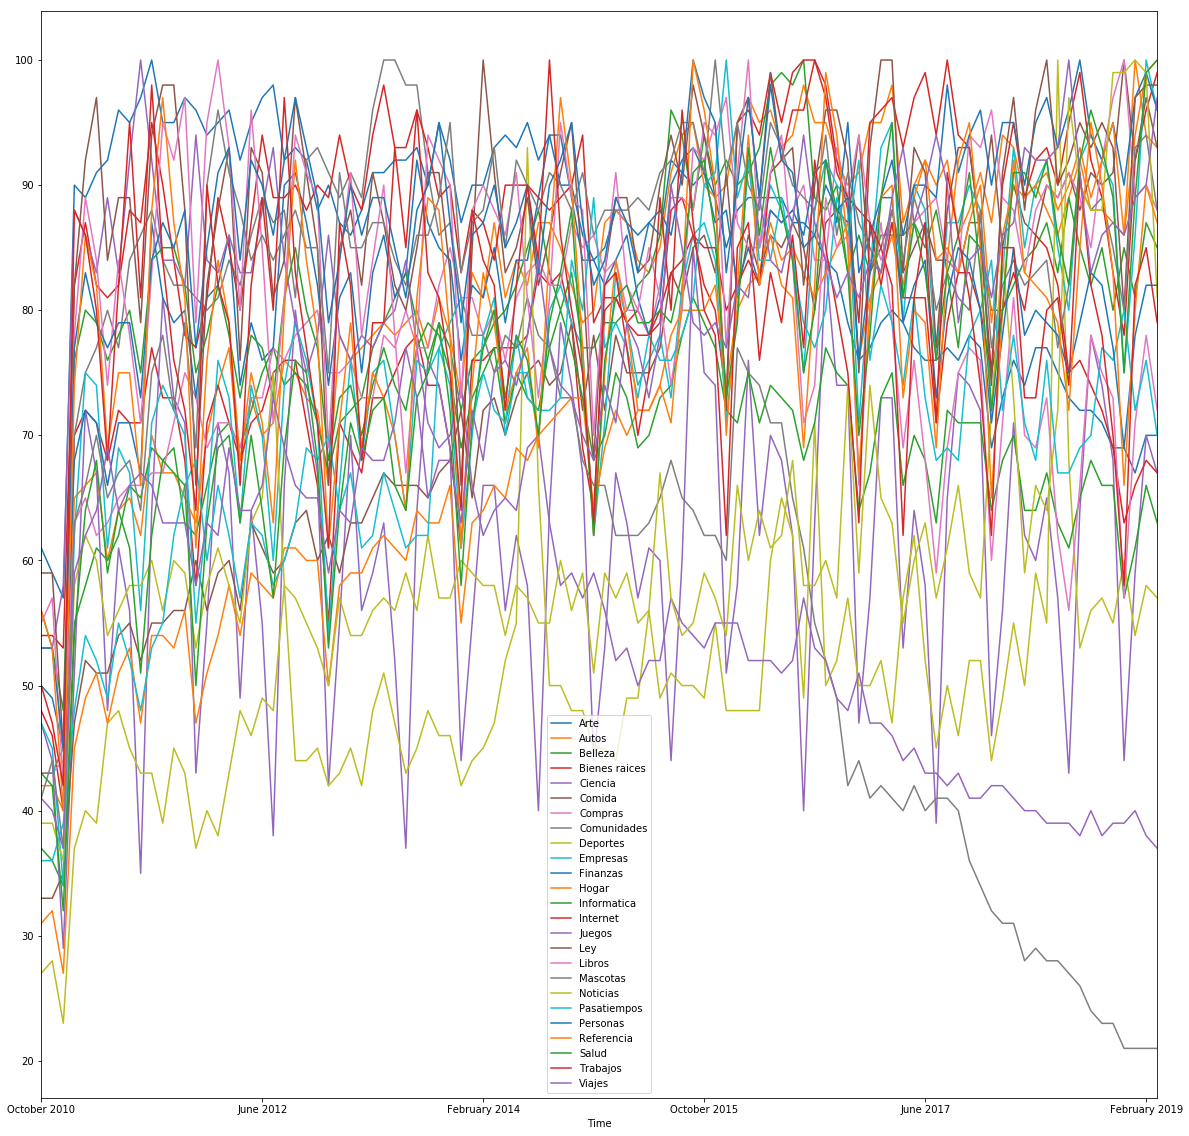

In [49]:
# Ploting the Google Trends information to find out stationalities, trends and substitute effects
# Graph plotted monthly: spagetti graph. Not very clear for understanding results


plt.rcParams['figure.figsize']=(10,6)
searches_date.plot(figsize=(20,20))

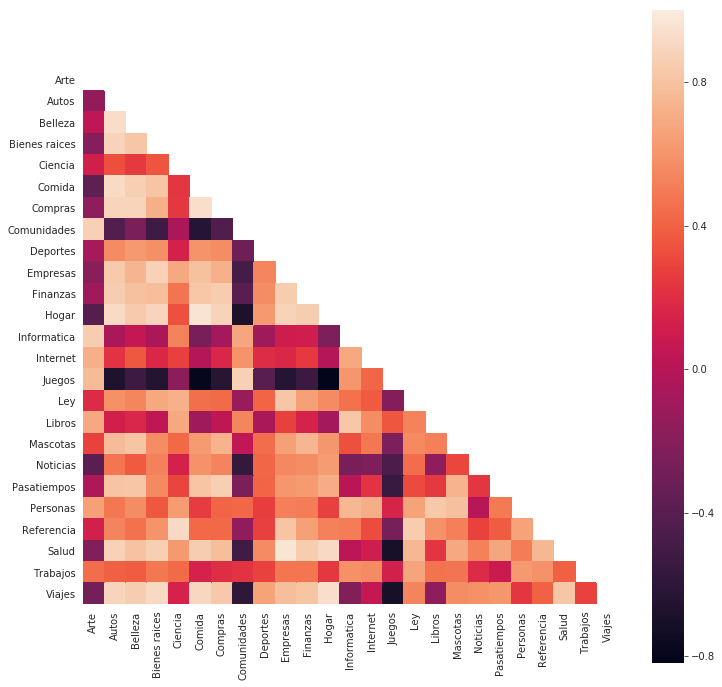

In [50]:
plt.rcParams['figure.figsize']=(12,12)

searches_corr = searches_date.corr()
mask = numpy.zeros_like(searches_corr)
mask[numpy.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(searches_corr, mask=mask, square=True)

In [51]:
# Selecting some important variables in which effects are identified

art_m=searches_date['Arte']
cars_m=searches_date['Autos']
beauty_m=searches_date['Hogar']
restate_m=searches_date['Bienes raices']
science_m=searches_date['Ciencia']
shoppings_m=searches_date['Compras']
communities_m=searches_date['Comunidades']
food_m=searches_date['Comida']
sports_m=searches_date['Deportes']
hobbies_m=searches_date['Pasatiempos']
health_m=searches_date['Salud']

[]

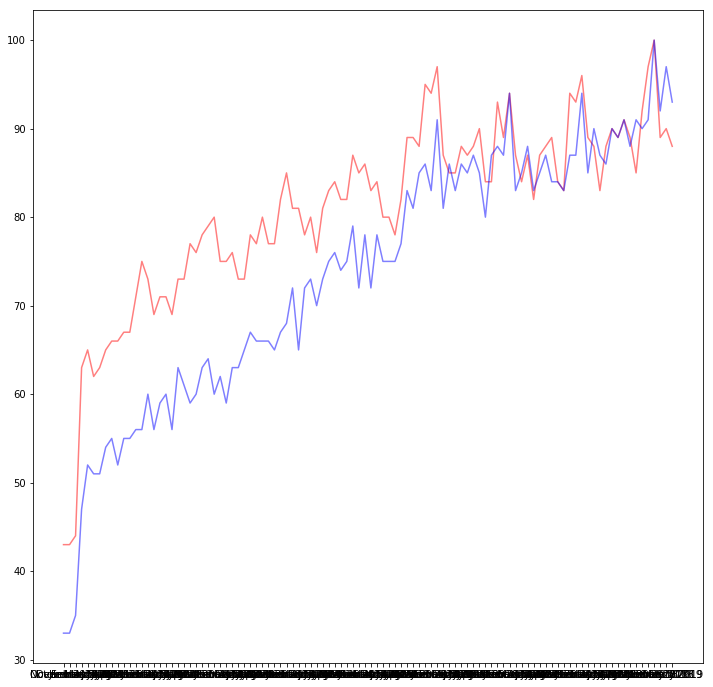

In [52]:
# Graph for the interesting findings
# Correlation of complements: Shoppings and food

plt.plot(searches_date.index, shoppings_m, color='red', alpha=0.5)
plt.plot(searches_date.index, food_m, color='blue', alpha=0.5)

plt.plot(figsize=(60,60))

[]

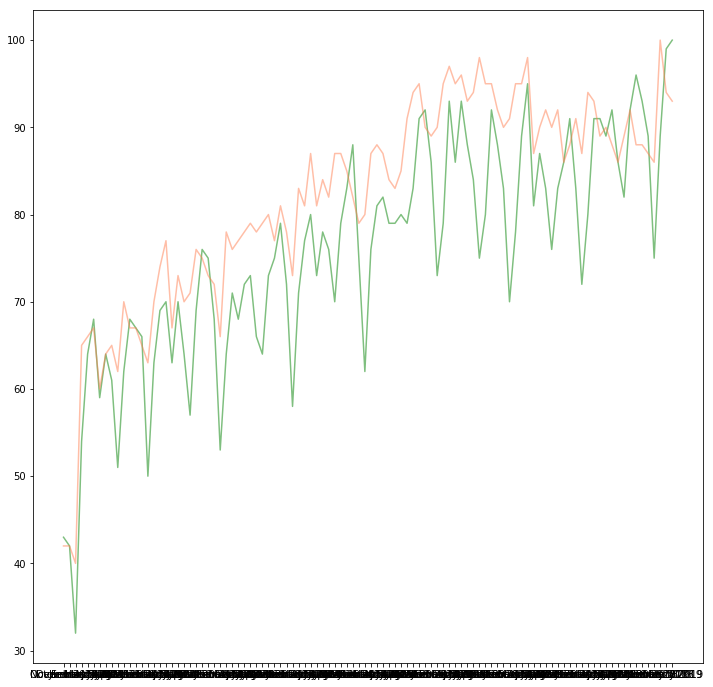

In [53]:
# Correlation for topics of lifestyle

plt.plot(searches_date.index, health_m, color='green', alpha=0.5)
plt.plot(searches_date.index, cars_m, color='coral', alpha=0.5)

plt.plot(figsize=(30,30))

[]

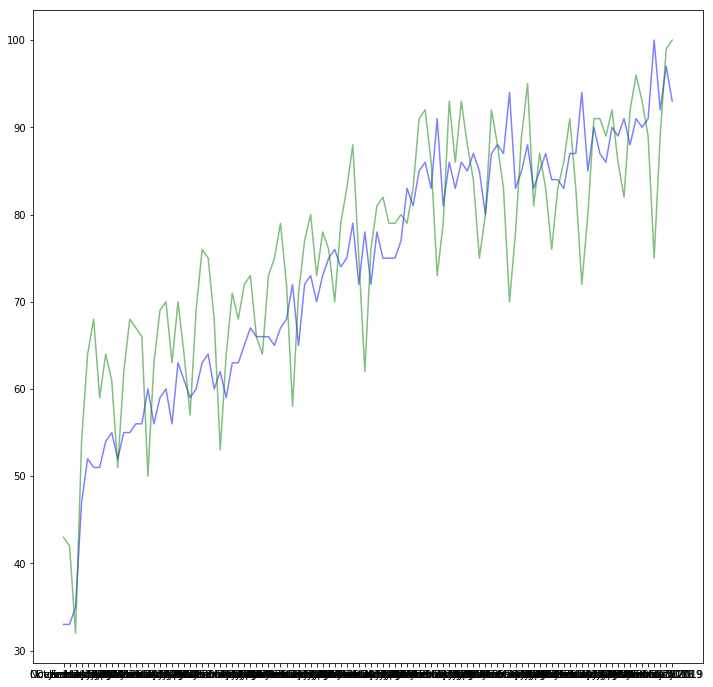

In [54]:
#Substitute effects in Deceber. While most of the variables fall in this month, food consistently grows year over year in this period. 
# Food and Health are inversely correlated in december. JAJA

plt.plot(searches_date.index, food_m, color='blue', alpha=0.5)
plt.plot(searches_date.index, health_m, color='green', alpha=0.5)

plt.plot(figsize=(30,30))

In [57]:
statsmodels.stats.weightstats.ttest_ind(gni, restate, alternative="two-sided")

(24.85207596972464, 1.6478728018204593e-16, 20.0)